# CNN Classifier for Plant Waves Using MFCC
---- 

#### PREPROCESSING: Create MFCC Images 
In this step, we compute the MFCC matrix, create MFCC images, reshape it to 97x97 images, and store them to disk with labels corresponding to classes and the number of sample.

In [ ]:
import numpy as np
import torch
import pickle
import os
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from python_speech_features import mfcc
from PIL import Image
from tqdm import tqdm

%run ../src/utils/constants.py

Load raw data that has been split into train, test, and validation sets for the 81k and 191k cases.

In [ ]:
path_to_pickle_train81k = DATASETS_DIR / "train-81k-stratified-without-neutral.pkl"
path_to_pickle_train191k = DATASETS_DIR / "train-191k-stratified-without-neutral.pkl"
path_to_pickle_test81k = DATASETS_DIR / "test-81k-stratified-without-neutral.pkl"
path_to_pickle_val81k = DATASETS_DIR / "val-81k-stratified-without-neutral.pkl"

In [ ]:
with open(path_to_pickle_train81k, 'rb') as train_81k_file:
    train_81k = pickle.load(train_81k_file)

In [ ]:
with open(path_to_pickle_train191k, 'rb') as train_191k_file:
    train_191k = pickle.load(train_191k_file)

In [ ]:
with open(path_to_pickle_test81k, 'rb') as test_81k_file:
    test_81k = pickle.load(test_81k_file)

In [ ]:
with open(path_to_pickle_val81k, 'rb') as val_81k_file:
    val_81k = pickle.load(val_81k_file)

Just in case you want to use the 191k dataset, run the following line of code. Don't load the `train_81k_file`.

In [ ]:
train_81k = train_191k
len(train_81k)

While ignoring the class `Neutral`, separate wave slices and labels, and create a Tensor dataset. 

In [ ]:
wav_slices = []
labels = []
for segment in val_81k:  # adjust this iterable for specific dataset.
    wav_slices.append(segment[0])
    labels.append(segment[1])

In [ ]:
wav_slices = torch.tensor(np.array(wav_slices), dtype=torch.float32)
labels = torch.tensor(np.array(labels), dtype=torch.long)
dataset = TensorDataset(wav_slices, labels)
print(wav_slices)

Normalize the samples using per-sample normalization.

In [ ]:
data_tensor, labels_tensor = dataset.tensors
mean = torch.mean(data_tensor, dim=1, keepdim=True)
std_dev = torch.std(data_tensor, dim=1, keepdim=True)
standardized_data = (data_tensor - mean) / (std_dev + 0.00000001)  # smoothing term to prevent zero division

dataset = TensorDataset(standardized_data, labels_tensor)

Extract the MFCC features and save the MFCC plots to disk as `.png`.

In [ ]:
train_81k_folder = "train-81k"
train_191k_folder = "train-191k"
test_81k_folder = "test-81k"
val_81k_folder = "val-81k"

In [ ]:
if not os.path.exists(MFCC_IMAGES_DIR / train_81k_folder):
    os.mkdir(MFCC_IMAGES_DIR / train_81k_folder)

if not os.path.exists(MFCC_IMAGES_DIR / train_191k_folder):
    os.mkdir(MFCC_IMAGES_DIR / train_191k_folder)

if not os.path.exists(MFCC_IMAGES_DIR / test_81k_folder):
    os.mkdir(MFCC_IMAGES_DIR / test_81k_folder)

if not os.path.exists(MFCC_IMAGES_DIR / val_81k_folder):
    os.mkdir(MFCC_IMAGES_DIR / val_81k_folder)

In [ ]:
count = 0 
for wav_slice, label in tqdm(dataset):
    mfcc_features = mfcc(wav_slice, samplerate=SAMPLING_RATE, winlen=0.025, winstep=0.010, numcep=13)

    file_name = f"{count}_mfcc_class_{label}.png"
    save_path = os.path.join(MFCC_IMAGES_DIR / val_81k_folder, file_name)  # Adjust train_191k_folder

    if not os.path.exists(save_path):
        plt.imshow(mfcc_features)
        plt.axis("off")
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        
    count += 1

----
#### PREPROCESSING: LOAD MFCC Images
Prepare the train data for the CNN.

In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


%run ../src/utils/constants.py

In [2]:
train_81k_folder = "train-81k"
#train_191k_folder = "train-191k"

In [7]:
# Load all MFCC images and file names. 
images_train = []
labels_train = []

image_filenames = os.listdir(MFCC_IMAGES_DIR / train_81k_folder)
image_paths = [os.path.join(MFCC_IMAGES_DIR / train_81k_folder, filename) for filename in image_filenames]

counter = 0
mfcc_store_dir = MFCC_IMAGES_DIR / "resized-images"

IMAGE_SIZE = (97,97)
N_CHANNELS = 1  # grey
for path in tqdm(image_paths): 
    file_name = os.path.basename(path)
    label_train = int(file_name.split(".")[0].split("_")[-1])    
    img = Image.open(path).convert("L")  # Make sure it is rgb (and not rgba which would give dim=4)
    img = img.resize(IMAGE_SIZE)

    if counter < 1000: 
        mfcc_file_name_store = os.path.join(mfcc_store_dir, f"resized_mfcc_{counter}_label_{map_int_to_label(label_train)}.png")
        if not os.path.exists(mfcc_file_name_store):
            img.save(mfcc_file_name_store)
        counter += 1
    
    img_array = np.array(img) / 255.0
    images_train.append(img_array)
    labels_train.append(label_train)

100%|███████████████████████████████████| 12130/12130 [00:46<00:00, 261.97it/s]


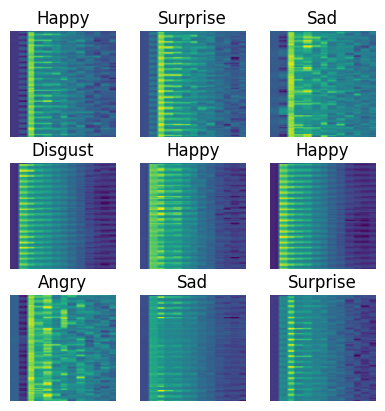

In [4]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_train[i])
    plt.title(f"{map_int_to_label(labels_train[i])}")  
    plt.axis("off")
plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(wspace=-0.45)
plt.show()

Prepare the val data for the CNN.

In [5]:
val_81k_folder = "val-81k"

In [6]:
# Load all MFCC images and file names. 
images_val = []
labels_val = []

image_filenames_val = os.listdir(MFCC_IMAGES_DIR / val_81k_folder)
image_paths_val = [os.path.join(MFCC_IMAGES_DIR / val_81k_folder, filename_val) for filename_val in image_filenames_val]

IMAGE_SIZE = (97,97)
N_CHANNELS = 1  # grey
for path_val in tqdm(image_paths_val): 
    file_name_val = os.path.basename(path_val)
    label_val = int(file_name_val.split(".")[0].split("_")[-1])    
    img_val = Image.open(path_val).convert("L")  # convert to greyscale
    img_val = img_val.resize(IMAGE_SIZE)
    img_array_val = np.array(img_val) / 255.0
    images_val.append(img_array_val)
    labels_val.append(label_val)

100%|████████████████████████████████████| 2600/2600 [00:02<00:00, 1101.71it/s]


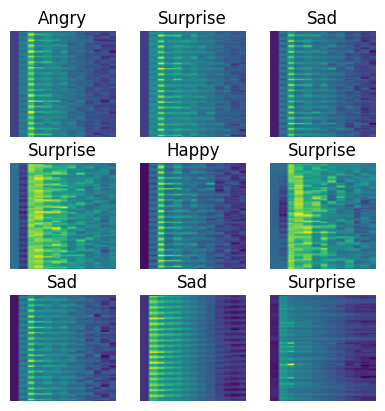

In [7]:
# plots inspired by https://www.kaggle.com/code/christianlillelund/classify-mnist-audio-using-spectrograms-keras-cnn
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_val[i])
    plt.title(f"{map_int_to_label(labels_val[i])}")  
    plt.axis("off")
plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(wspace=-0.45)

plt.show()

Create datasets and dataloaders.

In [8]:
images_train = torch.tensor(np.array(images_train), dtype=torch.float32)
images_train = images_train.unsqueeze(1)
labels_train = torch.tensor(np.array(labels_train), dtype=torch.long)
train81k_dataset = TensorDataset(images_train, labels_train)

images_val = torch.tensor(np.array(images_val), dtype=torch.float32)
images_val = images_val.unsqueeze(1)
labels_val = torch.tensor(np.array(labels_val), dtype=torch.long)
val81k_dataset = TensorDataset(images_val, labels_val)

In [9]:
batch_size = 32
train81k_loader = DataLoader(train81k_dataset, batch_size)
val81k_loader = DataLoader(val81k_dataset, batch_size)

#### Hyperparameter Optimization
Specify a study name and define the search space for the grid search. 

Run `PREPROCESSING: LOAD MFCC Images`.

In [10]:
import torch
import wandb
import math
import optuna
from optuna.trial import TrialState
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score

C:\Users\nekta\OneDrive\Desktop\botanic-emotion-recognition\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define the CNN model. Compute the hidden dimension of the transformed image successively. Images dimension are manipulated as follows:

1. Convolution layer: `output_dim` = `input_dim` - `filter_size` + `1`
2. Maxpool layer: `floor`((`input_dim`-`kernel_size`) / `stride`) + `1`

whereby the output dimension refers to either image height or image length. 

In [11]:
def define_model(trial):
    layers = []

    N_CLASSES = 6
    conv_kernel_size = trial.suggest_categorical(f"conv_kernel_size", [3, 5, 7])
    dropout_rate = trial.suggest_categorical("dropout_rate", [0.0, 0.1, 0.2])

    input_channels = 1
    out_channels_l1 = trial.suggest_categorical(f"out_channels_l1", [2 ** i for i in range(4, 8)])
    
    layers.append(torch.nn.Conv2d(input_channels, out_channels_l1, kernel_size=conv_kernel_size))
    hidden_img_height = IMAGE_SIZE[0] - conv_kernel_size + 1  # 93
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
    hidden_img_height = math.floor((hidden_img_height - 2) / 2) + 1 # 46
    layers.append(torch.nn.Dropout(dropout_rate))

    out_channels_l2 = trial.suggest_categorical(f"out_channels_l2", [2 ** i for i in range(4, 7)])

    layers.append(torch.nn.Conv2d(out_channels_l1, out_channels_l2, kernel_size=conv_kernel_size))
    hidden_img_height = hidden_img_height - conv_kernel_size + 1 # 42
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
    hidden_img_height = math.floor((hidden_img_height - 2) / 2) + 1 # 21
    layers.append(torch.nn.Dropout(dropout_rate))

    layers.append(torch.nn.Flatten())

    layers.append(torch.nn.Linear(out_channels_l2 * hidden_img_height * hidden_img_height, 64)) 
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Linear(64, N_CLASSES))

    config_dict = {
        "out_channels_l1": out_channels_l1,
        "out_channels_l2": out_channels_l2,
        "conv_kernel_size": conv_kernel_size,
        "dropout_rate": dropout_rate
    }

    return torch.nn.Sequential(*layers), config_dict

Define the objective function for optuna for the hyperparameter optimization.

In [12]:
def objective(trial): 
    model, config_dict = define_model(trial)

    lr = trial.suggest_categorical('lr', [0.0001, 0.001, 0.01])

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print(config_dict)
    name_experiment = (f"{trial.number}_{NAME_CORE}_lr-{lr}_convf1-{config_dict['out_channels_l1']}_convf2-"
                       f"{config_dict['out_channels_l2']}_convker-{config_dict['conv_kernel_size']}_dr-{config_dict['dropout_rate']}")

    config_dict["lr"] = lr
    config_dict["epochs"] = NUM_EPOCHS

    wandb.init(
        project="model_" + NAME_CORE + "-hpo",
        dir=LOGS_DIR,
        name=name_experiment,
        config=config_dict
    )


    for epoch in range(NUM_EPOCHS):
        model.train()
        for batch_data, batch_labels in tqdm(train81k_loader):          
            # zero gradients
            optimizer.zero_grad()

            # forward + backward pass
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

        all_preds = []
        all_labels = []

        model.eval()
        with torch.no_grad():
            for batch_data, batch_labels in tqdm(val81k_loader): 
                output = model(batch_data)

                predicted = output.argmax(dim=1)
                all_preds.extend(predicted.numpy())
                all_labels.extend(batch_labels.numpy())

        # TODO: explicitely state in written thesis that zero_division=0.0
        balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
        accuracy = accuracy_score(all_labels, all_preds)
        f1_class = f1_score(all_labels, all_preds, average=None, zero_division=0.0)
        f1_weighted = f1_score(all_labels, all_preds, average="weighted", zero_division=0.0)
        recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0.0)
        precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0.0)

        trial.report(balanced_accuracy, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

            
        metrics = {
            "balanced_accuracy": balanced_accuracy,
            "accuracy": accuracy,
            "f1_weighted": f1_weighted,
            "recall": recall,
            "precision": precision
        }

        wandb_input = metrics
        wandb.log(wandb_input)

    wandb.finish()

    return balanced_accuracy

Run hyperparameter optimization using optuna. 

In [13]:
search_space = {
    'lr': [0.0001, 0.001, 0.01],
    'out_channels_l1': [2 ** i for i in range(4, 8)],   # 4 values
    'out_channels_l2': [2 ** i for i in range(4, 7)],   # 3 values
    'conv_kernel_size': [3, 5, 7],
    "dropout_rate": [0.0, 0.1, 0.2]
}

In [14]:
num_combi = 1
for i in search_space:
    num_combi *= len(search_space[i])
num_combi

324

In [16]:
NAME_CORE = f"cnn_mfcc_6_grey_81k_numceps_13_searchspace_{num_combi}"
NUM_EPOCHS = 20
NAME_CORE

'cnn_mfcc_6_grey_81k_numceps_13_searchspace_324'

In [17]:
sampler = optuna.samplers.GridSampler(search_space)
study = optuna.create_study(sampler=sampler, study_name=NAME_CORE, storage="sqlite:///hpo_" + NAME_CORE + ".db",
                            direction="maximize", load_if_exists=True)
study.optimize(objective, n_trials=num_combi)

[I 2024-02-15 11:39:12,582] A new study created in RDB with name: cnn_mfcc_6_grey_81k_numceps_13_searchspace_324


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


wandb: Currently logged in as: totikos. Use `wandb login --relogin` to force relogin


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.89it/s]


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
balanced_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1_weighted,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.31731
balanced_accuracy,0.16667
f1_weighted,0.15286
precision,0.10068
recall,0.31731


[I 2024-02-15 12:11:39,120] Trial 0 finished with value: 0.16666666666666666 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.0, 'out_channels_l1': 32, 'out_channels_l2': 16, 'lr': 0.01}. Best is trial 0 with value: 0.16666666666666666.


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  5.95it/s]


accuracy,▁▁▃▆▆▆▆▇▇▇▇▇▇█▇█████
balanced_accuracy,▁▁▃▆▇▇▇▇▇▇▇█████████
f1_weighted,▁▁▃▆▆▇▇▇▇▇▇▇████████
precision,▁▄▄▅▅▆▆▇▇▇▇▇▇▇▇█████
recall,▁▁▃▆▆▆▆▇▇▇▇▇▇█▇█████
accuracy,0.53538
balanced_accuracy,0.37185
f1_weighted,0.52126
precision,0.5113
recall,0.53538


[I 2024-02-15 13:19:24,155] Trial 1 finished with value: 0.3718528101672462 and parameters: {'conv_kernel_size': 7, 'dropout_rate': 0.2, 'out_channels_l1': 32, 'out_channels_l2': 64, 'lr': 0.0001}. Best is trial 1 with value: 0.3718528101672462.


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.23it/s]


accuracy,▁▃▃▅▆▆▇▇▇▇▇▇▇███████
balanced_accuracy,▁▃▃▅▇▇▇▇▇███████████
f1_weighted,▁▄▄▆▇▇▇▇▇▇▇▇████████
precision,▅▂▁▃▆▆▇▇▇▇▇▇▇███████
recall,▁▃▃▅▆▆▇▇▇▇▇▇▇███████
accuracy,0.54346
balanced_accuracy,0.37717
f1_weighted,0.53139
precision,0.52372
recall,0.54346


[I 2024-02-15 14:02:07,512] Trial 2 finished with value: 0.3771694266661847 and parameters: {'conv_kernel_size': 7, 'dropout_rate': 0.0, 'out_channels_l1': 32, 'out_channels_l2': 32, 'lr': 0.0001}. Best is trial 2 with value: 0.3771694266661847.


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.08it/s]


accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
balanced_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1_weighted,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.31731
balanced_accuracy,0.16667
f1_weighted,0.15286
precision,0.10068
recall,0.31731


[I 2024-02-15 14:33:17,881] Trial 3 finished with value: 0.16666666666666666 and parameters: {'conv_kernel_size': 3, 'dropout_rate': 0.2, 'out_channels_l1': 32, 'out_channels_l2': 32, 'lr': 0.01}. Best is trial 2 with value: 0.3771694266661847.


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 12.11it/s]


accuracy,▁▃▄▄▅▆▆▇▇▇▇▇████████
balanced_accuracy,▁▂▄▄▅▆▆▇▇▇▇█████████
f1_weighted,▁▂▂▂▃▄▅▆▇▇▇█████████
precision,▁▁▂▄▅▆▆▇▇▇▇▇████████
recall,▁▃▄▄▅▆▆▇▇▇▇▇████████
accuracy,0.52038
balanced_accuracy,0.35786
f1_weighted,0.49791
precision,0.49122
recall,0.52038


[I 2024-02-15 15:05:24,073] Trial 4 finished with value: 0.35785505193796335 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.2, 'out_channels_l1': 16, 'out_channels_l2': 64, 'lr': 0.0001}. Best is trial 2 with value: 0.3771694266661847.


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.79it/s]


accuracy,▁▄▅▅▅▆▆▆▆▆▆▇▇▇▇█████
balanced_accuracy,▁▄▆▆▇▇▇▇▇▇▇▇▇███████
f1_weighted,▁▄▄▅▅▆▆▆▆▆▇▇▇▇▇█████
precision,▁▅▅▆▆▆▆▆▆▆▆▇▇▇▇█▇███
recall,▁▄▅▅▅▆▆▆▆▆▆▇▇▇▇█████
accuracy,0.54154
balanced_accuracy,0.37215
f1_weighted,0.52114
precision,0.51401
recall,0.54154


[I 2024-02-15 15:46:49,007] Trial 5 finished with value: 0.37214549280751824 and parameters: {'conv_kernel_size': 3, 'dropout_rate': 0.1, 'out_channels_l1': 32, 'out_channels_l2': 64, 'lr': 0.0001}. Best is trial 2 with value: 0.3771694266661847.


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:32<00:00,  2.55it/s]
[I 2024-02-15 15:53:40,046] Trial 6 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:03<00:00, 20.87it/s]
[I 2024-02-15 15:54:39,942] Trial 7 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 18.32it/s]
[I 2024-02-15 16:02:38,824] Trial 8 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


accuracy,▁▃▅▇███
balanced_accuracy,▁▃▅▇███
f1_weighted,▁▃▅▇███
precision,▁█▇███▇
recall,▁▃▅▇███
accuracy,0.47808
balanced_accuracy,0.33684
f1_weighted,0.42516
precision,0.46921
recall,0.47808


100%|██████████████████████████████████████████| 82/82 [00:03<00:00, 22.56it/s]
[I 2024-02-15 16:03:26,583] Trial 9 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.90it/s]


accuracy,▁▃▄▅▆▇▇▇▇▇▇█████████
balanced_accuracy,▁▃▃▄▆▇▇▇▇▇██████████
f1_weighted,▁▄▅▅▇▇▇▇▇▇██████████
precision,▁▃▄▄▆▇▇▇▇▇▇▇████████
recall,▁▃▄▅▆▇▇▇▇▇▇█████████
accuracy,0.54269
balanced_accuracy,0.37893
f1_weighted,0.52948
precision,0.51911
recall,0.54269


[I 2024-02-15 16:46:41,704] Trial 10 finished with value: 0.37893199426346896 and parameters: {'conv_kernel_size': 7, 'dropout_rate': 0.2, 'out_channels_l1': 32, 'out_channels_l2': 32, 'lr': 0.0001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:16<00:00,  4.94it/s]
[I 2024-02-15 16:50:07,590] Trial 11 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 12.36it/s]
[I 2024-02-15 16:51:34,947] Trial 12 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:18<00:00,  4.49it/s]


accuracy,▁▇▇▇██▇▇▇▇▇▆▆▇▆▇▆▆▆▇
balanced_accuracy,▁▇▇████▇▇▇▇▇▆▇▇▇▆▆▇▇
f1_weighted,▁▇▇█████▇▇▇▇▇▇▇▇▇▇▇▇
precision,▁▇▇▇██████▇▇▇▇▇▇▇▇▇▇
recall,▁▇▇▇██▇▇▇▇▇▆▆▇▆▇▆▆▆▇
accuracy,0.50923
balanced_accuracy,0.35515
f1_weighted,0.49372
precision,0.49163
recall,0.50923


[I 2024-02-15 18:15:10,459] Trial 13 finished with value: 0.35515144938562376 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.0, 'out_channels_l1': 64, 'out_channels_l2': 64, 'lr': 0.001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:23<00:00,  3.51it/s]
[I 2024-02-15 18:19:06,564] Trial 14 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.93it/s]


accuracy,▁▄▆▆▇▇██▇██████████▇
balanced_accuracy,▁▅▇▇▇██████████████▇
f1_weighted,▁▅▇▇▇██████████████▇
precision,▁▆▇▇▇████████████▇▇▇
recall,▁▄▆▆▇▇██▇██████████▇
accuracy,0.52962
balanced_accuracy,0.36374
f1_weighted,0.5111
precision,0.50493
recall,0.52962


[I 2024-02-15 18:49:59,256] Trial 15 finished with value: 0.36373501111478196 and parameters: {'conv_kernel_size': 3, 'dropout_rate': 0.0, 'out_channels_l1': 32, 'out_channels_l2': 32, 'lr': 0.001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:19<00:00,  4.21it/s]
[I 2024-02-15 18:54:08,107] Trial 16 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:29<00:00,  2.76it/s]
[I 2024-02-15 18:58:57,997] Trial 17 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 16.06it/s]
[I 2024-02-15 19:01:14,774] Trial 18 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.40038
balanced_accuracy,0.2356
f1_weighted,0.33967
precision,0.32456
recall,0.40038


100%|██████████████████████████████████████████| 82/82 [00:21<00:00,  3.83it/s]


accuracy,▁▆▇▇█▇█▇█▇▇▇▇█▇█▇███
balanced_accuracy,▁▇▇▇█▇█▇█▇▇▇▇█▇█████
f1_weighted,▁▇▇▇█▇█▇█▇▇▇▇█▇█▇███
precision,▁▆▇▇█▇█▇█▇▇▇▇█▇█▇███
recall,▁▆▇▇█▇█▇█▇▇▇▇█▇█▇███
accuracy,0.53038
balanced_accuracy,0.3681
f1_weighted,0.51542
precision,0.50778
recall,0.53038


[I 2024-02-15 20:36:53,463] Trial 19 finished with value: 0.36809921569080645 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.2, 'out_channels_l1': 64, 'out_channels_l2': 64, 'lr': 0.001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.29it/s]
[I 2024-02-15 20:39:09,313] Trial 20 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:28<00:00,  2.91it/s]
[I 2024-02-15 20:44:11,186] Trial 21 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:20<00:00,  3.91it/s]


accuracy,▁▃▅▆▆▆▆▇▇▇▇▇▇███████
balanced_accuracy,▁▄▇▇▇▇▇▇▇███████████
f1_weighted,▁▄▆▆▇▆▇▇▇▇▇█▇███████
precision,▁▄▆▆▆▆▇▇▇▇▇▇▇███████
recall,▁▃▅▆▆▆▆▇▇▇▇▇▇███████
accuracy,0.53615
balanced_accuracy,0.37255
f1_weighted,0.52505
precision,0.51863
recall,0.53615


[I 2024-02-15 22:20:08,532] Trial 22 finished with value: 0.3725523885699171 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.1, 'out_channels_l1': 64, 'out_channels_l2': 64, 'lr': 0.0001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.60it/s]


accuracy,▁▅▆▆▇████▇█▇▇██▆▆▆▄▅
balanced_accuracy,▁▅▆▆▇████▇█▇███▇▆▆▅▆
f1_weighted,▁▅▆▆▇████▇█▇███▇▇▅▅▅
precision,▁▄▅▅▇████▇█████▆▆▅▄▅
recall,▁▅▆▆▇████▇█▇▇██▆▆▆▄▅
accuracy,0.49615
balanced_accuracy,0.35102
f1_weighted,0.48535
precision,0.48151
recall,0.49615


[I 2024-02-15 23:14:35,863] Trial 23 finished with value: 0.3510191248813796 and parameters: {'conv_kernel_size': 3, 'dropout_rate': 0.1, 'out_channels_l1': 64, 'out_channels_l2': 16, 'lr': 0.001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:47<00:00,  1.72it/s]
[I 2024-02-15 23:27:01,627] Trial 24 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:24<00:00,  3.34it/s]
[I 2024-02-15 23:33:09,750] Trial 25 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 14.08it/s]


accuracy,▁▆▆▇▇████▇▇▇▆▆▆▅▄▄▅▄
balanced_accuracy,▁▆▇▇▇█████▇▇▇▇▇▆▅▆▆▆
f1_weighted,▁▆▇▇▇█████▇▇▇▇▆▆▅▅▆▅
precision,▁▇▇▇▇████▇▇▇▇▇▆▆▅▅▆▅
recall,▁▆▆▇▇████▇▇▇▆▆▆▅▄▄▅▄
accuracy,0.47846
balanced_accuracy,0.33699
f1_weighted,0.4692
precision,0.46197
recall,0.47846


[I 2024-02-16 00:01:36,338] Trial 26 finished with value: 0.3369852052545598 and parameters: {'conv_kernel_size': 7, 'dropout_rate': 0.1, 'out_channels_l1': 16, 'out_channels_l2': 32, 'lr': 0.001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:37<00:00,  2.20it/s]
[I 2024-02-16 00:19:53,587] Trial 27 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.41462
balanced_accuracy,0.2632
f1_weighted,0.39514
precision,0.42011
recall,0.41462


100%|██████████████████████████████████████████| 82/82 [00:33<00:00,  2.42it/s]
[I 2024-02-16 00:47:36,947] Trial 28 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


accuracy,▁▇█
balanced_accuracy,▁▆█
f1_weighted,▁▅█
precision,▁█▅
recall,▁▇█
accuracy,0.47654
balanced_accuracy,0.34073
f1_weighted,0.45244
precision,0.45485
recall,0.47654


100%|██████████████████████████████████████████| 82/82 [00:17<00:00,  4.65it/s]
[I 2024-02-16 01:04:21,688] Trial 29 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


accuracy,▁▅▆█
balanced_accuracy,▁▆▇█
f1_weighted,▁▆▆█
precision,▁▄▇█
recall,▁▅▆█
accuracy,0.50885
balanced_accuracy,0.35524
f1_weighted,0.49775
precision,0.49805
recall,0.50885


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.32it/s]
[I 2024-02-16 01:11:08,965] Trial 30 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.42808
balanced_accuracy,0.27035
f1_weighted,0.40114
precision,0.422
recall,0.42808


100%|██████████████████████████████████████████| 82/82 [00:10<00:00,  7.75it/s]
[I 2024-02-16 01:29:02,012] Trial 31 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


accuracy,▁▆▆▇▇██
balanced_accuracy,▁▇▇▇███
f1_weighted,▁▇▆▇▇██
precision,▁▆▅▆▇▇█
recall,▁▆▆▇▇██
accuracy,0.52923
balanced_accuracy,0.3638
f1_weighted,0.51346
precision,0.50653
recall,0.52923


100%|██████████████████████████████████████████| 82/82 [00:34<00:00,  2.41it/s]
[I 2024-02-16 01:45:44,903] Trial 32 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.39769
balanced_accuracy,0.25157
f1_weighted,0.36971
precision,0.36306
recall,0.39769


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 18.23it/s]
[I 2024-02-16 01:46:54,961] Trial 33 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:29<00:00,  2.78it/s]
[I 2024-02-16 01:53:27,570] Trial 34 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  6.17it/s]
[I 2024-02-16 01:56:41,542] Trial 35 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:36<00:00,  2.23it/s]
[I 2024-02-16 02:05:04,326] Trial 36 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:31<00:00,  2.62it/s]
[I 2024-02-16 02:28:52,822] Trial 37 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


accuracy,▁▁█
balanced_accuracy,██▁
f1_weighted,▂▁█
precision,▁▃█
recall,▁▁█
accuracy,0.48038
balanced_accuracy,0.31782
f1_weighted,0.46769
precision,0.47847
recall,0.48038


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.21it/s]
[I 2024-02-16 02:31:24,005] Trial 38 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 19.11it/s]


accuracy,▁▂▂▅▆▆▆▇▇▇▇▇█▇▇▇▇▇▇▇
balanced_accuracy,▁▃▃▆▇▇▇▇▇▇█▇█▇▇▇▇▇▇▇
f1_weighted,▁▂▁▅▅▆▆▆▆▇▇▇█▇▇▇▇▇▇▇
precision,▃▁▁▄▄▅▅▆▆▆▇▇█▇▇▇▇▇██
recall,▁▂▂▅▆▆▆▇▇▇▇▇█▇▇▇▇▇▇▇
accuracy,0.54615
balanced_accuracy,0.37538
f1_weighted,0.53003
precision,0.53685
recall,0.54615


[I 2024-02-16 02:48:37,412] Trial 39 finished with value: 0.37538299090211974 and parameters: {'conv_kernel_size': 3, 'dropout_rate': 0.1, 'out_channels_l1': 16, 'out_channels_l2': 16, 'lr': 0.001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:44<00:00,  1.84it/s]
[I 2024-02-16 02:59:52,781] Trial 40 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.09it/s]
[I 2024-02-16 03:03:12,744] Trial 41 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.42308
balanced_accuracy,0.26445
f1_weighted,0.3728
precision,0.40194
recall,0.42308


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.85it/s]
[I 2024-02-16 03:04:38,775] Trial 42 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.91it/s]
[I 2024-02-16 03:10:57,559] Trial 43 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


accuracy,▁▅█
balanced_accuracy,▁▆█
f1_weighted,▁▅█
precision,▁█▆
recall,▁▅█
accuracy,0.48731
balanced_accuracy,0.34328
f1_weighted,0.47444
precision,0.46832
recall,0.48731


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.81it/s]
[I 2024-02-16 03:12:54,337] Trial 44 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:29<00:00,  2.76it/s]


accuracy,▁▆▆▆▆▇▇█▇▇██████████
balanced_accuracy,▁▇▇▇▇▇▇█████████████
f1_weighted,▁▆▇▆▇▇▇█████████████
precision,▁▆▇▇▇▇▇█████████████
recall,▁▆▆▆▆▇▇█▇▇██████████
accuracy,0.54154
balanced_accuracy,0.37796
f1_weighted,0.52749
precision,0.51664
recall,0.54154


[I 2024-02-16 05:26:00,125] Trial 45 finished with value: 0.3779586875193952 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.2, 'out_channels_l1': 128, 'out_channels_l2': 32, 'lr': 0.0001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:33<00:00,  2.42it/s]
[I 2024-02-16 05:42:25,525] Trial 46 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.43115
balanced_accuracy,0.26584
f1_weighted,0.38607
precision,0.42083
recall,0.43115


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  6.12it/s]
[I 2024-02-16 05:44:57,063] Trial 47 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:16<00:00,  5.12it/s]


accuracy,▁▅▇▇▇▇██▇▅▄▆▇▇▇▇▆▃▄▄
balanced_accuracy,▁▅▇▇▇▇██▇▂▂▃▆▆▇▇▅▂▃▃
f1_weighted,▁▅▇▇▇████▅▄▆█▇█▇▆▄▅▅
precision,▂▁▅▆▆▆▇█▇▅▄▇█▇▇▆▅▁▁▂
recall,▁▅▇▇▇▇██▇▅▄▆▇▇▇▇▆▃▄▄
accuracy,0.50346
balanced_accuracy,0.34117
f1_weighted,0.49127
precision,0.48594
recall,0.50346


[I 2024-02-16 06:48:29,005] Trial 48 finished with value: 0.3411685074392114 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.0, 'out_channels_l1': 64, 'out_channels_l2': 32, 'lr': 0.001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:33<00:00,  2.43it/s]
[I 2024-02-16 06:56:24,398] Trial 49 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:34<00:00,  2.39it/s]
[I 2024-02-16 07:04:30,656] Trial 50 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.47it/s]
[I 2024-02-16 07:07:22,622] Trial 51 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:22<00:00,  3.66it/s]


accuracy,▁▅▅██████▇▆▇▇▇██▇▆▅▄
balanced_accuracy,▁▅▆██████▇▇▇▇███▆▆▅▅
f1_weighted,▁▅▅▇██████▇▇████▆▆▅▄
precision,▁▅▄▇██▇██████▇▇▇▆▆▅▄
recall,▁▅▅██████▇▆▇▇▇██▇▆▅▄
accuracy,0.49654
balanced_accuracy,0.33816
f1_weighted,0.47944
precision,0.4868
recall,0.49654


[I 2024-02-16 09:03:40,369] Trial 52 finished with value: 0.338157116361725 and parameters: {'conv_kernel_size': 7, 'dropout_rate': 0.0, 'out_channels_l1': 64, 'out_channels_l2': 64, 'lr': 0.001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.93it/s]
[I 2024-02-16 09:05:28,343] Trial 53 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:28<00:00,  2.85it/s]
[I 2024-02-16 09:12:03,180] Trial 54 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:17<00:00,  4.63it/s]
[I 2024-02-16 09:22:32,282] Trial 55 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


accuracy,▁█
balanced_accuracy,▁█
f1_weighted,▁█
precision,█▁
recall,▁█
accuracy,0.47038
balanced_accuracy,0.32428
f1_weighted,0.45159
precision,0.44226
recall,0.47038


100%|██████████████████████████████████████████| 82/82 [00:32<00:00,  2.49it/s]
[I 2024-02-16 09:27:52,775] Trial 56 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:10<00:00,  8.16it/s]
[I 2024-02-16 09:29:57,579] Trial 57 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:16<00:00,  5.11it/s]
[I 2024-02-16 09:34:56,905] Trial 58 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:38<00:00,  2.15it/s]
[I 2024-02-16 09:43:03,913] Trial 59 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.30it/s]
[I 2024-02-16 09:44:45,250] Trial 60 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 14.45it/s]


accuracy,▁▆▇▇█▇██▇█▇▇▇▇█▇█▆▆▆
balanced_accuracy,▁▇▇██▇██▇█▇▇▇▇█▆█▆▆▆
f1_weighted,▁▆▇▇█▇██▇███▇▇█▇█▆▆▆
precision,▁▇▇▇█▇██▇███▇▇█▇▇▆▆▆
recall,▁▆▇▇█▇██▇█▇▇▇▇█▇█▆▆▆
accuracy,0.50654
balanced_accuracy,0.34799
f1_weighted,0.49225
precision,0.49178
recall,0.50654


[I 2024-02-16 10:16:59,782] Trial 61 finished with value: 0.34798931254724663 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.1, 'out_channels_l1': 16, 'out_channels_l2': 32, 'lr': 0.001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00, 10.04it/s]
[I 2024-02-16 10:18:54,768] Trial 62 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:33<00:00,  2.46it/s]
[I 2024-02-16 10:25:45,720] Trial 63 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:32<00:00,  2.53it/s]
[I 2024-02-16 10:46:01,602] Trial 64 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


accuracy,▁█
balanced_accuracy,▁█
f1_weighted,▁█
precision,▁█
recall,▁█
accuracy,0.47269
balanced_accuracy,0.33245
f1_weighted,0.45538
precision,0.44957
recall,0.47269


100%|██████████████████████████████████████████| 82/82 [00:31<00:00,  2.57it/s]
[I 2024-02-16 10:51:50,675] Trial 65 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.32it/s]
[I 2024-02-16 10:53:59,416] Trial 66 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.21it/s]
[I 2024-02-16 10:57:05,871] Trial 67 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:29<00:00,  2.79it/s]
[I 2024-02-16 11:10:57,672] Trial 68 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.435
balanced_accuracy,0.25907
f1_weighted,0.36922
precision,0.41636
recall,0.435


100%|██████████████████████████████████████████| 82/82 [00:18<00:00,  4.44it/s]
[I 2024-02-16 11:14:31,609] Trial 69 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:34<00:00,  2.36it/s]
[I 2024-02-16 11:23:00,727] Trial 70 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.53it/s]
[I 2024-02-16 11:25:37,269] Trial 71 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 17.03it/s]
[I 2024-02-16 11:26:44,782] Trial 72 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:29<00:00,  2.80it/s]
[I 2024-02-16 11:37:35,211] Trial 73 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.43654
balanced_accuracy,0.26547
f1_weighted,0.38595
precision,0.44382
recall,0.43654


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 16.66it/s]


accuracy,▁▂▅▅▆▆▇▇▇▇▇▇▇██▇▇██▅
balanced_accuracy,▁▃▅▅▆▆▇▇▇▇▇▇▇▇█▇███▇
f1_weighted,▁▃▅▅▆▆▇▇▇▇▇▇▇██▇███▆
precision,▁▁▄▃▄▄▅▆▆▅▆▅▅██▆▆▇▆▅
recall,▁▂▅▅▆▆▇▇▇▇▇▇▇██▇▇██▅
accuracy,0.52269
balanced_accuracy,0.3731
f1_weighted,0.5161
precision,0.5126
recall,0.52269


[I 2024-02-16 11:56:39,622] Trial 74 finished with value: 0.37309924163275904 and parameters: {'conv_kernel_size': 3, 'dropout_rate': 0.2, 'out_channels_l1': 16, 'out_channels_l2': 16, 'lr': 0.001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 15.36it/s]
[I 2024-02-16 11:57:50,949] Trial 75 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:16<00:00,  4.85it/s]
[I 2024-02-16 12:01:24,524] Trial 76 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 19.64it/s]
[I 2024-02-16 12:02:16,141] Trial 77 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.91it/s]
[I 2024-02-16 12:03:51,083] Trial 78 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 14.47it/s]
[I 2024-02-16 12:05:12,377] Trial 79 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:11<00:00,  7.22it/s]
[I 2024-02-16 12:07:49,400] Trial 80 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 12.50it/s]
[I 2024-02-16 12:09:15,028] Trial 81 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:39<00:00,  2.08it/s]
[I 2024-02-16 12:17:05,585] Trial 82 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:12<00:00,  6.55it/s]
[I 2024-02-16 12:19:56,068] Trial 83 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:33<00:00,  2.42it/s]
[I 2024-02-16 12:28:35,417] Trial 84 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.31it/s]
[I 2024-02-16 12:35:38,372] Trial 85 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


accuracy,▁▄▇█
balanced_accuracy,▁▅██
f1_weighted,▁▅██
precision,▁▄▇█
recall,▁▄▇█
accuracy,0.52154
balanced_accuracy,0.36167
f1_weighted,0.50385
precision,0.49496
recall,0.52154


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.76it/s]
[I 2024-02-16 12:41:26,417] Trial 86 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.42385
balanced_accuracy,0.26836
f1_weighted,0.39723
precision,0.42987
recall,0.42385


100%|██████████████████████████████████████████| 82/82 [00:45<00:00,  1.82it/s]
[I 2024-02-16 12:52:46,381] Trial 87 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  6.28it/s]
[I 2024-02-16 12:56:09,260] Trial 88 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.81it/s]
[I 2024-02-16 12:57:46,629] Trial 89 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00, 10.08it/s]
[I 2024-02-16 12:59:46,192] Trial 90 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.27it/s]
[I 2024-02-16 13:03:34,279] Trial 91 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.45538
balanced_accuracy,0.29104
f1_weighted,0.42636
precision,0.44131
recall,0.45538


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 18.62it/s]
[I 2024-02-16 13:04:33,509] Trial 92 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:30<00:00,  2.72it/s]
[I 2024-02-16 13:11:24,880] Trial 93 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 12.24it/s]
[I 2024-02-16 13:14:20,180] Trial 94 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.44038
balanced_accuracy,0.28768
f1_weighted,0.4238
precision,0.422
recall,0.44038


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.74it/s]
[I 2024-02-16 13:24:54,071] Trial 95 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


accuracy,▁▇▇██
balanced_accuracy,▁████
f1_weighted,▁▇███
precision,▁▇███
recall,▁▇▇██
accuracy,0.52808
balanced_accuracy,0.36679
f1_weighted,0.51317
precision,0.50322
recall,0.52808


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.57it/s]
[I 2024-02-16 13:26:43,030] Trial 96 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:17<00:00,  4.79it/s]
[I 2024-02-16 13:30:24,625] Trial 97 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:10<00:00,  7.55it/s]
[I 2024-02-16 13:32:44,177] Trial 98 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:40<00:00,  2.02it/s]
[I 2024-02-16 13:41:20,317] Trial 99 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:26<00:00,  3.06it/s]
[I 2024-02-16 13:46:10,508] Trial 100 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.50it/s]
[I 2024-02-16 13:47:50,500] Trial 101 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 13.38it/s]
[I 2024-02-16 13:49:18,198] Trial 102 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:23<00:00,  3.43it/s]
[I 2024-02-16 13:55:21,963] Trial 103 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.39it/s]
[I 2024-02-16 13:57:04,048] Trial 104 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:20<00:00,  4.06it/s]
[I 2024-02-16 14:00:37,906] Trial 105 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:29<00:00,  2.80it/s]
[I 2024-02-16 14:07:09,559] Trial 106 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.99it/s]
[I 2024-02-16 14:08:45,244] Trial 107 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.86it/s]
[I 2024-02-16 14:12:24,345] Trial 108 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.38923
balanced_accuracy,0.26863
f1_weighted,0.32762
precision,0.38057
recall,0.38923


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.72it/s]
[I 2024-02-16 14:15:16,179] Trial 109 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.64it/s]
[I 2024-02-16 14:18:38,017] Trial 110 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:17<00:00,  4.61it/s]
[I 2024-02-16 14:26:56,181] Trial 111 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.42808
balanced_accuracy,0.26376
f1_weighted,0.37695
precision,0.42306
recall,0.42808


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  6.24it/s]
[I 2024-02-16 14:30:14,081] Trial 112 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.22it/s]
[I 2024-02-16 14:34:00,246] Trial 113 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.28it/s]
[I 2024-02-16 14:35:58,856] Trial 114 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 20.26it/s]
[I 2024-02-16 14:36:55,559] Trial 115 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:12<00:00,  6.45it/s]
[I 2024-02-16 14:39:38,940] Trial 116 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 14.92it/s]
[I 2024-02-16 14:40:57,893] Trial 117 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00, 10.07it/s]
[I 2024-02-16 14:44:24,052] Trial 118 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.46731
balanced_accuracy,0.3114
f1_weighted,0.43808
precision,0.43648
recall,0.46731


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.53it/s]
[I 2024-02-16 14:46:24,612] Trial 119 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:35<00:00,  2.29it/s]
[I 2024-02-16 14:54:33,092] Trial 120 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:27<00:00,  2.99it/s]
[I 2024-02-16 15:00:14,338] Trial 121 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:17<00:00,  4.63it/s]
[I 2024-02-16 15:04:35,656] Trial 122 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:29<00:00,  2.76it/s]
[I 2024-02-16 15:11:08,819] Trial 123 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.59it/s]
[I 2024-02-16 15:12:50,064] Trial 124 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.40it/s]
[I 2024-02-16 15:15:09,439] Trial 125 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:23<00:00,  3.51it/s]
[I 2024-02-16 15:21:01,115] Trial 126 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 17.81it/s]
[I 2024-02-16 15:22:12,750] Trial 127 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 14.35it/s]
[I 2024-02-16 15:23:38,250] Trial 128 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:23<00:00,  3.44it/s]
[I 2024-02-16 15:29:47,134] Trial 129 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.68it/s]
[I 2024-02-16 15:31:27,628] Trial 130 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:16<00:00,  4.98it/s]
[I 2024-02-16 15:34:50,072] Trial 131 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.61it/s]
[I 2024-02-16 15:38:58,476] Trial 132 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.41308
balanced_accuracy,0.26178
f1_weighted,0.36815
precision,0.39599
recall,0.41308


100%|██████████████████████████████████████████| 82/82 [00:28<00:00,  2.83it/s]
[I 2024-02-16 15:45:01,187] Trial 133 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.21it/s]
[I 2024-02-16 15:47:37,292] Trial 134 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:28<00:00,  2.91it/s]
[I 2024-02-16 16:04:15,527] Trial 135 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


accuracy,▁█
balanced_accuracy,▁█
f1_weighted,▁█
precision,▁█
recall,▁█
accuracy,0.49846
balanced_accuracy,0.34552
f1_weighted,0.48333
precision,0.47391
recall,0.49846


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 15.30it/s]
[I 2024-02-16 16:05:32,810] Trial 136 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.25it/s]
[I 2024-02-16 16:07:33,629] Trial 137 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 12.16it/s]
[I 2024-02-16 16:11:54,406] Trial 138 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


accuracy,▁█
balanced_accuracy,▁█
f1_weighted,▁█
precision,▁█
recall,▁█
accuracy,0.48308
balanced_accuracy,0.33715
f1_weighted,0.429
precision,0.45774
recall,0.48308


100%|██████████████████████████████████████████| 82/82 [00:18<00:00,  4.45it/s]
[I 2024-02-16 16:18:39,734] Trial 139 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.38885
balanced_accuracy,0.27579
f1_weighted,0.36461
precision,0.39929
recall,0.38885


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.50it/s]
[I 2024-02-16 16:20:45,186] Trial 140 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:22<00:00,  3.67it/s]
[I 2024-02-16 16:25:34,503] Trial 141 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.20it/s]
[I 2024-02-16 16:29:32,265] Trial 142 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 17.33it/s]
[I 2024-02-16 16:30:40,420] Trial 143 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  6.24it/s]
[I 2024-02-16 16:33:22,120] Trial 144 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.47it/s]
[I 2024-02-16 16:36:13,604] Trial 145 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.44692
balanced_accuracy,0.29368
f1_weighted,0.42604
precision,0.45058
recall,0.44692


100%|██████████████████████████████████████████| 82/82 [00:16<00:00,  5.00it/s]
[I 2024-02-16 16:50:26,730] Trial 146 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


accuracy,▁▇▇█
balanced_accuracy,▁█▇█
f1_weighted,▁███
precision,▁█▇█
recall,▁▇▇█
accuracy,0.51769
balanced_accuracy,0.3589
f1_weighted,0.50233
precision,0.4927
recall,0.51769


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.80it/s]
[I 2024-02-16 16:52:29,988] Trial 147 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 17.76it/s]
[I 2024-02-16 16:53:29,947] Trial 148 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:45<00:00,  1.81it/s]
[I 2024-02-16 17:04:39,694] Trial 149 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:17<00:00,  4.61it/s]
[I 2024-02-16 17:08:11,022] Trial 150 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 13.85it/s]
[I 2024-02-16 17:09:50,687] Trial 151 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:17<00:00,  4.71it/s]
[I 2024-02-16 17:13:05,425] Trial 152 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [01:07<00:00,  1.22it/s]
[I 2024-02-16 17:34:02,281] Trial 153 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.41385
balanced_accuracy,0.28416
f1_weighted,0.35308
precision,0.47723
recall,0.41385


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.79it/s]
[I 2024-02-16 17:36:54,488] Trial 154 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.41it/s]
[I 2024-02-16 17:48:28,145] Trial 155 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


accuracy,▁█
balanced_accuracy,▁█
f1_weighted,▁█
precision,▁█
recall,▁█
accuracy,0.50808
balanced_accuracy,0.34299
f1_weighted,0.49179
precision,0.49094
recall,0.50808


100%|██████████████████████████████████████████| 82/82 [00:45<00:00,  1.80it/s]
[I 2024-02-16 17:59:55,115] Trial 156 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:17<00:00,  4.62it/s]
[I 2024-02-16 18:03:50,439] Trial 157 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00, 10.24it/s]
[I 2024-02-16 18:05:33,803] Trial 158 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.31it/s]
[I 2024-02-16 18:07:27,537] Trial 159 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:11<00:00,  7.10it/s]
[I 2024-02-16 18:09:59,143] Trial 160 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.54it/s]
[I 2024-02-16 18:14:20,463] Trial 161 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.41885
balanced_accuracy,0.25762
f1_weighted,0.38688
precision,0.4154
recall,0.41885


100%|██████████████████████████████████████████| 82/82 [00:08<00:00, 10.11it/s]
[I 2024-02-16 18:16:13,496] Trial 162 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:24<00:00,  3.41it/s]
[I 2024-02-16 18:21:17,545] Trial 163 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:12<00:00,  6.40it/s]
[I 2024-02-16 18:23:58,602] Trial 164 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.29it/s]
[I 2024-02-16 18:24:58,773] Trial 165 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:12<00:00,  6.69it/s]
[I 2024-02-16 18:29:36,386] Trial 166 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.43654
balanced_accuracy,0.27309
f1_weighted,0.38943
precision,0.38796
recall,0.43654


100%|██████████████████████████████████████████| 82/82 [00:19<00:00,  4.24it/s]
[I 2024-02-16 18:33:37,511] Trial 167 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:28<00:00,  2.83it/s]
[I 2024-02-16 18:40:05,269] Trial 168 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00, 10.10it/s]
[I 2024-02-16 18:47:58,444] Trial 169 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


accuracy,▁▅▇█
balanced_accuracy,▁▆██
f1_weighted,▁▅▇█
precision,▁▅▇█
recall,▁▅▇█
accuracy,0.52192
balanced_accuracy,0.35895
f1_weighted,0.50169
precision,0.49553
recall,0.52192


100%|██████████████████████████████████████████| 82/82 [00:16<00:00,  4.88it/s]
[I 2024-02-16 18:51:57,499] Trial 170 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:33<00:00,  2.44it/s]
[I 2024-02-16 18:58:43,836] Trial 171 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.44it/s]
[I 2024-02-16 19:01:36,093] Trial 172 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:30<00:00,  2.65it/s]
[I 2024-02-16 19:07:40,751] Trial 173 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:11<00:00,  7.09it/s]
[I 2024-02-16 19:10:06,030] Trial 174 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:31<00:00,  2.59it/s]
[I 2024-02-16 19:35:56,847] Trial 175 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


accuracy,▁▇█
balanced_accuracy,▁▇█
f1_weighted,▁▆█
precision,▁▇█
recall,▁▇█
accuracy,0.49577
balanced_accuracy,0.35028
f1_weighted,0.47806
precision,0.47442
recall,0.49577


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 11.81it/s]
[I 2024-02-16 19:37:29,588] Trial 176 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  5.94it/s]
[I 2024-02-16 19:53:49,270] Trial 177 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


accuracy,▁▆▇██
balanced_accuracy,▁▆▇██
f1_weighted,▁▆▇██
precision,▁▆▇██
recall,▁▆▇██
accuracy,0.53462
balanced_accuracy,0.36553
f1_weighted,0.51982
precision,0.51501
recall,0.53462


100%|██████████████████████████████████████████| 82/82 [00:21<00:00,  3.87it/s]
[I 2024-02-16 20:04:29,241] Trial 178 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.40385
balanced_accuracy,0.27981
f1_weighted,0.34191
precision,0.3027
recall,0.40385


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 19.19it/s]
[I 2024-02-16 20:05:28,232] Trial 179 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:37<00:00,  2.21it/s]
[I 2024-02-16 20:13:31,043] Trial 180 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:29<00:00,  2.78it/s]


accuracy,▁▄▆▇█████▇▇▆▆▅▆▆▆▅▅▄
balanced_accuracy,▁▃▆▇▇████▆▇▅▆▄▆▅▅▄▄▂
f1_weighted,▁▃▅▇█████▇▇▆▆▄▅▅▅▄▅▄
precision,▁▃▅▇▇███▇▆▇▆▆▄▅▅▅▅▅▄
recall,▁▄▆▇█████▇▇▆▆▅▆▆▆▅▅▄
accuracy,0.51385
balanced_accuracy,0.35184
f1_weighted,0.4976
precision,0.49319
recall,0.51385


[I 2024-02-16 22:18:49,688] Trial 181 finished with value: 0.351842347325001 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.0, 'out_channels_l1': 128, 'out_channels_l2': 32, 'lr': 0.001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 18.78it/s]
[I 2024-02-16 22:19:48,167] Trial 182 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 11.89it/s]
[I 2024-02-16 22:22:32,645] Trial 183 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.42269
balanced_accuracy,0.26875
f1_weighted,0.39177
precision,0.41076
recall,0.42269


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.45it/s]
[I 2024-02-16 22:24:30,288] Trial 184 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:27<00:00,  3.02it/s]
[I 2024-02-16 22:29:18,308] Trial 185 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:11<00:00,  7.35it/s]
[I 2024-02-16 22:32:39,120] Trial 186 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:20<00:00,  4.05it/s]
[I 2024-02-16 22:38:25,573] Trial 187 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.45it/s]
[I 2024-02-16 22:42:05,416] Trial 188 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  6.09it/s]
[I 2024-02-16 22:45:43,870] Trial 189 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:32<00:00,  2.54it/s]
[I 2024-02-16 22:51:53,020] Trial 190 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:11<00:00,  6.99it/s]


accuracy,▁▅▆▇▇▇█▇█████▇▇▇▆▆▆▆
balanced_accuracy,▁▅▆▇▇▇▇▇██▇█▇▇▇▇▇▇▇▇
f1_weighted,▁▅▆▇▇▇████▇█▇▇▇▇▆▆▆▆
precision,▁▄▅▆▇▇████▇█▇▇▇▇▇▆▇▆
recall,▁▅▆▇▇▇█▇█████▇▇▇▆▆▆▆
accuracy,0.52231
balanced_accuracy,0.36658
f1_weighted,0.50934
precision,0.50402
recall,0.52231


[I 2024-02-16 23:42:50,093] Trial 191 finished with value: 0.36657677412138984 and parameters: {'conv_kernel_size': 3, 'dropout_rate': 0.2, 'out_channels_l1': 32, 'out_channels_l2': 64, 'lr': 0.001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.58it/s]
[I 2024-02-16 23:44:35,253] Trial 192 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.07it/s]
[I 2024-02-16 23:46:13,105] Trial 193 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:42<00:00,  1.92it/s]
[I 2024-02-16 23:56:11,454] Trial 194 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.28it/s]
[I 2024-02-17 00:00:01,420] Trial 195 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.34it/s]
[I 2024-02-17 00:22:06,914] Trial 196 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


accuracy,▁▆█▆▇
balanced_accuracy,▁▆█▇▇
f1_weighted,▁▇█▇█
precision,▁▆▇▇█
recall,▁▆█▆▇
accuracy,0.52115
balanced_accuracy,0.35795
f1_weighted,0.50917
precision,0.50511
recall,0.52115


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.68it/s]
[I 2024-02-17 00:27:40,514] Trial 197 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.47231
balanced_accuracy,0.31262
f1_weighted,0.42959
precision,0.4457
recall,0.47231


100%|██████████████████████████████████████████| 82/82 [00:26<00:00,  3.08it/s]
[I 2024-02-17 00:48:32,332] Trial 198 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


accuracy,▁▇█
balanced_accuracy,▁▇█
f1_weighted,▁▇█
precision,▁██
recall,▁▇█
accuracy,0.52
balanced_accuracy,0.35862
f1_weighted,0.5029
precision,0.49542
recall,0.52


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.38it/s]
[I 2024-02-17 00:51:25,742] Trial 199 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.43654
balanced_accuracy,0.28438
f1_weighted,0.41499
precision,0.41168
recall,0.43654


100%|██████████████████████████████████████████| 82/82 [00:11<00:00,  6.86it/s]
[I 2024-02-17 00:57:51,825] Trial 200 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.45769
balanced_accuracy,0.29623
f1_weighted,0.42442
precision,0.42587
recall,0.45769


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.31it/s]
[I 2024-02-17 00:59:50,928] Trial 201 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 15.57it/s]
[I 2024-02-17 01:01:16,953] Trial 202 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:16<00:00,  5.04it/s]
[I 2024-02-17 01:05:13,066] Trial 203 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.08it/s]
[I 2024-02-17 01:06:48,576] Trial 204 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 17.31it/s]
[I 2024-02-17 01:07:55,203] Trial 205 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:11<00:00,  6.94it/s]
[I 2024-02-17 01:10:22,526] Trial 206 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:10<00:00,  7.63it/s]
[I 2024-02-17 01:12:30,210] Trial 207 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:25<00:00,  3.25it/s]
[I 2024-02-17 01:41:29,801] Trial 208 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


accuracy,▁▇██
balanced_accuracy,▁▇██
f1_weighted,▁▇▇█
precision,▁▆▇█
recall,▁▇██
accuracy,0.525
balanced_accuracy,0.36081
f1_weighted,0.51239
precision,0.5076
recall,0.525


100%|██████████████████████████████████████████| 82/82 [00:37<00:00,  2.16it/s]
[I 2024-02-17 01:49:13,812] Trial 209 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  5.92it/s]
[I 2024-02-17 01:54:40,351] Trial 210 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.41615
balanced_accuracy,0.27681
f1_weighted,0.35827
precision,0.47612
recall,0.41615


100%|██████████████████████████████████████████| 82/82 [00:12<00:00,  6.70it/s]
[I 2024-02-17 01:57:18,721] Trial 211 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:32<00:00,  2.54it/s]
[I 2024-02-17 02:30:38,123] Trial 212 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


accuracy,▁▇██
balanced_accuracy,▁▇██
f1_weighted,▁▇██
precision,▁▇██
recall,▁▇██
accuracy,0.51731
balanced_accuracy,0.357
f1_weighted,0.49938
precision,0.49389
recall,0.51731


100%|██████████████████████████████████████████| 82/82 [00:26<00:00,  3.04it/s]
[I 2024-02-17 02:35:25,794] Trial 213 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:45<00:00,  1.79it/s]
[I 2024-02-17 02:57:07,566] Trial 214 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.42385
balanced_accuracy,0.26623
f1_weighted,0.36816
precision,0.38583
recall,0.42385


100%|██████████████████████████████████████████| 82/82 [00:03<00:00, 20.51it/s]


accuracy,▁▆▇▇█▇▇████▇█▇▆▇▆▅▆▆
balanced_accuracy,▁▇▇███▇████▇██▇▇▆▆▇▇
f1_weighted,▁▇▇███▇████▇▇▇▆▆▅▆▆▆
precision,▁▇▆▇█▇▇████▇▇▇▆▆▅▅▆▇
recall,▁▆▇▇█▇▇████▇█▇▆▇▆▅▆▆
accuracy,0.51769
balanced_accuracy,0.37156
f1_weighted,0.50761
precision,0.51618
recall,0.51769


[I 2024-02-17 03:14:57,881] Trial 215 finished with value: 0.371555746553274 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.2, 'out_channels_l1': 16, 'out_channels_l2': 16, 'lr': 0.001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:20<00:00,  4.02it/s]
[I 2024-02-17 03:19:18,648] Trial 216 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:17<00:00,  4.69it/s]
[I 2024-02-17 03:23:00,330] Trial 217 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:27<00:00,  2.98it/s]
[I 2024-02-17 03:29:07,216] Trial 218 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  5.97it/s]
[I 2024-02-17 03:31:51,845] Trial 219 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.42it/s]
[I 2024-02-17 03:33:13,208] Trial 220 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:26<00:00,  3.07it/s]
[I 2024-02-17 03:44:03,789] Trial 221 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.39077
balanced_accuracy,0.26826
f1_weighted,0.32434
precision,0.3087
recall,0.39077


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.93it/s]
[I 2024-02-17 03:55:20,883] Trial 222 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


accuracy,▁▇▇██
balanced_accuracy,▁█▇██
f1_weighted,▁▇▇██
precision,▁▆▆██
recall,▁▇▇██
accuracy,0.53731
balanced_accuracy,0.36742
f1_weighted,0.52292
precision,0.51825
recall,0.53731


100%|██████████████████████████████████████████| 82/82 [00:28<00:00,  2.90it/s]
[I 2024-02-17 04:01:02,377] Trial 223 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:29<00:00,  2.77it/s]
[I 2024-02-17 04:07:42,961] Trial 224 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 17.92it/s]
[I 2024-02-17 04:08:50,308] Trial 225 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 15.99it/s]
[I 2024-02-17 04:11:50,139] Trial 226 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


accuracy,▁█
balanced_accuracy,▁█
f1_weighted,▁█
precision,▁█
recall,▁█
accuracy,0.50462
balanced_accuracy,0.35084
f1_weighted,0.49047
precision,0.48115
recall,0.50462


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.28it/s]
[I 2024-02-17 04:14:50,996] Trial 227 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.46731
balanced_accuracy,0.29869
f1_weighted,0.42462
precision,0.45826
recall,0.46731


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 16.16it/s]
[I 2024-02-17 04:15:56,410] Trial 228 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:17<00:00,  4.63it/s]
[I 2024-02-17 04:20:04,168] Trial 229 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:40<00:00,  2.04it/s]
[I 2024-02-17 04:28:42,278] Trial 230 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.76it/s]
[I 2024-02-17 04:31:27,008] Trial 231 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.69it/s]
[I 2024-02-17 04:34:12,360] Trial 232 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.57it/s]
[I 2024-02-17 04:37:23,173] Trial 233 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.36it/s]
[I 2024-02-17 04:39:14,098] Trial 234 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.85it/s]
[I 2024-02-17 04:42:31,778] Trial 235 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.32it/s]
[I 2024-02-17 04:44:22,176] Trial 236 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:10<00:00,  7.94it/s]
[I 2024-02-17 04:50:09,020] Trial 237 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


accuracy,▁█
balanced_accuracy,▁█
f1_weighted,▁█
precision,█▁
recall,▁█
accuracy,0.49423
balanced_accuracy,0.34585
f1_weighted,0.48066
precision,0.47473
recall,0.49423


100%|██████████████████████████████████████████| 82/82 [00:10<00:00,  8.00it/s]
[I 2024-02-17 04:52:10,298] Trial 238 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.51it/s]
[I 2024-02-17 04:55:40,406] Trial 239 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:44<00:00,  1.86it/s]
[I 2024-02-17 05:06:52,269] Trial 240 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  6.01it/s]
[I 2024-02-17 05:09:37,262] Trial 241 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:23<00:00,  3.54it/s]
[I 2024-02-17 05:15:16,735] Trial 242 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 15.05it/s]
[I 2024-02-17 05:16:29,452] Trial 243 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 16.70it/s]
[I 2024-02-17 05:17:40,281] Trial 244 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:28<00:00,  2.87it/s]
[I 2024-02-17 05:24:01,812] Trial 245 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:12<00:00,  6.38it/s]
[I 2024-02-17 05:29:27,868] Trial 246 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.43615
balanced_accuracy,0.29424
f1_weighted,0.41725
precision,0.43662
recall,0.43615


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.29it/s]
[I 2024-02-17 05:31:27,206] Trial 247 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 12.24it/s]
[I 2024-02-17 05:34:15,185] Trial 248 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.46038
balanced_accuracy,0.29517
f1_weighted,0.42962
precision,0.43787
recall,0.46038


100%|██████████████████████████████████████████| 82/82 [00:10<00:00,  7.71it/s]
[I 2024-02-17 05:39:21,439] Trial 249 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.41423
balanced_accuracy,0.26347
f1_weighted,0.37233
precision,0.3853
recall,0.41423


100%|██████████████████████████████████████████| 82/82 [00:16<00:00,  5.10it/s]
[I 2024-02-17 05:43:21,777] Trial 250 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:22<00:00,  3.69it/s]
[I 2024-02-17 05:48:16,957] Trial 251 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.17it/s]
[I 2024-02-17 05:49:41,054] Trial 252 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:03<00:00, 21.47it/s]
[I 2024-02-17 05:50:32,982] Trial 253 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 19.35it/s]
[I 2024-02-17 05:51:26,927] Trial 254 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.33it/s]
[I 2024-02-17 05:53:46,160] Trial 255 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:22<00:00,  3.58it/s]
[I 2024-02-17 05:59:14,286] Trial 256 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:24<00:00,  3.32it/s]
[I 2024-02-17 06:04:45,737] Trial 257 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.18it/s]
[I 2024-02-17 06:06:40,754] Trial 258 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.52it/s]
[I 2024-02-17 06:09:59,306] Trial 259 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 18.88it/s]


accuracy,▁▅▅▇▇███▇▇▆▇▆▇▇▆▆▅▃▄
balanced_accuracy,▁▅▆▇▇███▇█▆▇▇█▇▇▇▆▅▅
f1_weighted,▁▄▅▇▇████▇▆▆▇▇▇▆▆▅▃▄
precision,▁▄▅▇▇████▇▆▆▆▇▇▆▆▅▃▃
recall,▁▅▅▇▇███▇▇▆▇▆▇▇▆▆▅▃▄
accuracy,0.49077
balanced_accuracy,0.34711
f1_weighted,0.47798
precision,0.4709
recall,0.49077


[I 2024-02-17 06:28:12,479] Trial 260 finished with value: 0.34711154726301974 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.1, 'out_channels_l1': 16, 'out_channels_l2': 16, 'lr': 0.001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:28<00:00,  2.93it/s]
[I 2024-02-17 06:33:28,406] Trial 261 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00, 10.21it/s]
[I 2024-02-17 06:35:02,302] Trial 262 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 18.13it/s]
[I 2024-02-17 06:35:59,355] Trial 263 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.69it/s]
[I 2024-02-17 06:43:23,918] Trial 264 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


accuracy,▁█
balanced_accuracy,▁█
f1_weighted,▁█
precision,▁█
recall,▁█
accuracy,0.50231
balanced_accuracy,0.34542
f1_weighted,0.47153
precision,0.47286
recall,0.50231


100%|██████████████████████████████████████████| 82/82 [00:26<00:00,  3.06it/s]
[I 2024-02-17 06:49:06,609] Trial 265 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:27<00:00,  3.00it/s]
[I 2024-02-17 06:55:57,570] Trial 266 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 17.69it/s]
[I 2024-02-17 07:00:07,823] Trial 267 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


accuracy,▁▅█
balanced_accuracy,▁▆█
f1_weighted,▁▅█
precision,▁▄█
recall,▁▅█
accuracy,0.52154
balanced_accuracy,0.3581
f1_weighted,0.50162
precision,0.49577
recall,0.52154


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.57it/s]
[I 2024-02-17 07:02:06,388] Trial 268 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:06<00:00, 11.77it/s]
[I 2024-02-17 07:03:41,906] Trial 269 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:34<00:00,  2.38it/s]
[I 2024-02-17 07:12:01,240] Trial 270 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.57it/s]
[I 2024-02-17 07:16:21,592] Trial 271 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


accuracy,▁█
balanced_accuracy,▁█
f1_weighted,▁█
precision,▁█
recall,▁█
accuracy,0.49654
balanced_accuracy,0.34467
f1_weighted,0.48238
precision,0.47203
recall,0.49654


100%|██████████████████████████████████████████| 82/82 [00:10<00:00,  7.54it/s]
[I 2024-02-17 07:18:46,813] Trial 272 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:25<00:00,  3.24it/s]
[I 2024-02-17 07:31:58,083] Trial 273 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


accuracy,▁█
balanced_accuracy,▁█
f1_weighted,▁█
precision,▁█
recall,▁█
accuracy,0.49192
balanced_accuracy,0.34379
f1_weighted,0.47888
precision,0.47528
recall,0.49192


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 14.85it/s]
[I 2024-02-17 07:33:23,084] Trial 274 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:30<00:00,  2.65it/s]
[I 2024-02-17 07:39:32,926] Trial 275 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:29<00:00,  2.76it/s]
[I 2024-02-17 07:45:49,873] Trial 276 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.27it/s]
[I 2024-02-17 07:49:13,066] Trial 277 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 16.03it/s]
[I 2024-02-17 07:51:17,030] Trial 278 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.44154
balanced_accuracy,0.29911
f1_weighted,0.42345
precision,0.42282
recall,0.44154


100%|██████████████████████████████████████████| 82/82 [00:13<00:00,  6.06it/s]
[I 2024-02-17 08:00:55,831] Trial 279 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


accuracy,▁██
balanced_accuracy,▁██
f1_weighted,▁██
precision,▁██
recall,▁██
accuracy,0.51269
balanced_accuracy,0.35792
f1_weighted,0.49323
precision,0.4851
recall,0.51269


100%|██████████████████████████████████████████| 82/82 [00:31<00:00,  2.62it/s]
[I 2024-02-17 08:13:53,287] Trial 280 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.45038
balanced_accuracy,0.28662
f1_weighted,0.38993
precision,0.43366
recall,0.45038


100%|██████████████████████████████████████████| 82/82 [00:09<00:00,  8.46it/s]
[I 2024-02-17 08:16:12,604] Trial 281 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:40<00:00,  2.01it/s]
[I 2024-02-17 08:27:18,574] Trial 282 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 17.84it/s]
[I 2024-02-17 08:28:19,880] Trial 283 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:19<00:00,  4.11it/s]
[I 2024-02-17 08:53:59,148] Trial 284 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


accuracy,▁▃▆▇█
balanced_accuracy,▁▅▇██
f1_weighted,▁▂▆██
precision,▁▃▅▇█
recall,▁▃▆▇█
accuracy,0.53077
balanced_accuracy,0.366
f1_weighted,0.51203
precision,0.50723
recall,0.53077


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.22it/s]
[I 2024-02-17 08:57:18,019] Trial 285 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.71it/s]
[I 2024-02-17 08:59:14,042] Trial 286 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 16.55it/s]
[I 2024-02-17 09:00:29,826] Trial 287 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:44<00:00,  1.86it/s]
[I 2024-02-17 09:11:10,850] Trial 288 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:24<00:00,  3.31it/s]
[I 2024-02-17 09:16:06,676] Trial 289 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.46it/s]
[I 2024-02-17 09:18:07,269] Trial 290 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.84it/s]
[I 2024-02-17 09:19:42,633] Trial 291 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.42it/s]
[I 2024-02-17 09:23:23,821] Trial 292 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 17.45it/s]
[I 2024-02-17 09:24:28,235] Trial 293 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 16.13it/s]
[I 2024-02-17 09:25:44,463] Trial 294 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 13.78it/s]
[I 2024-02-17 09:27:13,597] Trial 295 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:17<00:00,  4.60it/s]
[I 2024-02-17 09:37:25,616] Trial 296 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


accuracy,▁█
balanced_accuracy,▁█
f1_weighted,▁█
precision,▁█
recall,▁█
accuracy,0.49423
balanced_accuracy,0.34643
f1_weighted,0.47771
precision,0.47004
recall,0.49423


100%|██████████████████████████████████████████| 82/82 [00:18<00:00,  4.32it/s]
[I 2024-02-17 09:41:39,368] Trial 297 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.79it/s]
[I 2024-02-17 09:43:39,453] Trial 298 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 14.92it/s]
[I 2024-02-17 09:44:57,784] Trial 299 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.79it/s]
[I 2024-02-17 09:47:36,350] Trial 300 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:26<00:00,  3.15it/s]
[I 2024-02-17 09:52:16,511] Trial 301 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:21<00:00,  3.73it/s]
[I 2024-02-17 09:57:56,137] Trial 302 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:15<00:00,  5.21it/s]
[I 2024-02-17 10:00:52,332] Trial 303 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 32, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:16<00:00,  5.03it/s]
[I 2024-02-17 10:04:12,189] Trial 304 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.42it/s]
[I 2024-02-17 10:05:52,765] Trial 305 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 14.11it/s]
[I 2024-02-17 10:07:19,870] Trial 306 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 32, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:33<00:00,  2.44it/s]


accuracy,▁▅▆▇██▇██▇█▇████▇▇▇█
balanced_accuracy,▁▅▇▇█▇▇██▇█▇█████▇▇█
f1_weighted,▁▅▇▇█████▇█▇█████▇▇█
precision,▁▃▅▇████▇▆█▆▇▇▇▇▆▆▄▆
recall,▁▅▆▇██▇██▇█▇████▇▇▇█
accuracy,0.53962
balanced_accuracy,0.37836
f1_weighted,0.52774
precision,0.5173
recall,0.53962


[I 2024-02-17 13:03:14,457] Trial 307 finished with value: 0.3783601605522772 and parameters: {'conv_kernel_size': 7, 'dropout_rate': 0.0, 'out_channels_l1': 128, 'out_channels_l2': 32, 'lr': 0.001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.24it/s]
[I 2024-02-17 13:04:40,477] Trial 308 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 11.40it/s]


accuracy,▁▅▆▅▆▆▇▇▇▆█▇▆▃▄▆▆▆▆▆
balanced_accuracy,▁▆▆▆▇▇██▇▇█▇▇▄▅▇▆▇▇▇
f1_weighted,▁▆▆▆▆▇▆▇▇▇█▇▇▅▅▇▆▇▆▇
precision,▁▄▅▄▅▅▅▆▆▆█▆▆▃▄▅▅▆▅▅
recall,▁▅▆▅▆▆▇▇▇▆█▇▆▃▄▆▆▆▆▆
accuracy,0.52846
balanced_accuracy,0.36789
f1_weighted,0.51488
precision,0.50532
recall,0.52846


[I 2024-02-17 13:40:43,414] Trial 309 finished with value: 0.3678896001270307 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.2, 'out_channels_l1': 16, 'out_channels_l2': 64, 'lr': 0.001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 64, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:20<00:00,  3.91it/s]
[I 2024-02-17 13:45:26,594] Trial 310 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.69it/s]
[I 2024-02-17 13:48:00,871] Trial 311 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:28<00:00,  2.90it/s]
[I 2024-02-17 13:53:38,123] Trial 312 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 15.99it/s]
[I 2024-02-17 13:54:54,044] Trial 313 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 7, 'dropout_rate': 0.0}


100%|██████████████████████████████████████████| 82/82 [00:28<00:00,  2.84it/s]
[I 2024-02-17 14:01:47,586] Trial 314 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:37<00:00,  2.18it/s]
[I 2024-02-17 14:10:41,342] Trial 315 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:07<00:00, 10.35it/s]


accuracy,▁▆▇▇▇█▇▇██▇▇█▇▇▇▆▇▇▆
balanced_accuracy,▁▇▇▇▇█▇███▇███▇▇▇██▇
f1_weighted,▁▆▇▇▇█▇█████▇▇▇▇▆▇▇▆
precision,▁▆▇▇▇███████▇▇▇▇▇▇█▇
recall,▁▆▇▇▇█▇▇██▇▇█▇▇▇▆▇▇▆
accuracy,0.52346
balanced_accuracy,0.36605
f1_weighted,0.51036
precision,0.51078
recall,0.52346


[I 2024-02-17 14:44:48,185] Trial 316 finished with value: 0.3660528435318506 and parameters: {'conv_kernel_size': 5, 'dropout_rate': 0.2, 'out_channels_l1': 32, 'out_channels_l2': 16, 'lr': 0.001}. Best is trial 10 with value: 0.37893199426346896.


{'out_channels_l1': 16, 'out_channels_l2': 32, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:05<00:00, 15.62it/s]
[I 2024-02-17 14:45:55,669] Trial 317 pruned. 


{'out_channels_l1': 128, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:25<00:00,  3.18it/s]
[I 2024-02-17 14:55:59,806] Trial 318 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.0}


accuracy,▁
balanced_accuracy,▁
f1_weighted,▁
precision,▁
recall,▁
accuracy,0.41692
balanced_accuracy,0.28472
f1_weighted,0.36826
precision,0.41694
recall,0.41692


100%|██████████████████████████████████████████| 82/82 [00:08<00:00,  9.79it/s]
[I 2024-02-17 14:57:46,611] Trial 319 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 17.16it/s]
[I 2024-02-17 14:58:54,391] Trial 320 pruned. 


{'out_channels_l1': 32, 'out_channels_l2': 64, 'conv_kernel_size': 5, 'dropout_rate': 0.1}


100%|██████████████████████████████████████████| 82/82 [00:12<00:00,  6.67it/s]
[I 2024-02-17 15:01:44,777] Trial 321 pruned. 


{'out_channels_l1': 64, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:14<00:00,  5.47it/s]
[I 2024-02-17 15:04:30,774] Trial 322 pruned. 


{'out_channels_l1': 16, 'out_channels_l2': 16, 'conv_kernel_size': 3, 'dropout_rate': 0.2}


100%|██████████████████████████████████████████| 82/82 [00:04<00:00, 18.43it/s]
[I 2024-02-17 15:05:31,931] Trial 323 pruned. 


Closer look into the trials. 

In [18]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

In [19]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of complete trials: ", len(complete_trials))
print("  Number of pruned trials: ", len(pruned_trials))

print("Best trial:")
trial_ = study.best_trial

print("  Value: ", trial_.value)
print("  Params: ")
for key, value in trial_.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  324
  Number of complete trials:  26
  Number of pruned trials:  298
Best trial:
  Value:  0.37893199426346896
  Params: 
    conv_kernel_size: 7
    dropout_rate: 0.2
    out_channels_l1: 32
    out_channels_l2: 32
    lr: 0.0001


####RUN with numceps=26  
Study statistics: 
  Number of finished trials:  324
  Number of complete trials:  13
  Number of pruned trials:  311
Best trial:
  Value:  0.380230058325653
  Params: 
    conv_kernel_size: 5
    dropout_rate: 0.0
    out_channels_l1: 16
    out_channels_l2: 16
    lr: 0.001

#### Training the CNN.
10 times training with best HP from HPO, and then average. 

In [1]:
import torch
print(torch.__version__)

2.0.1+cpu


#### Testing the Classifier

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

%run ../src/utils/constants.py

In [ ]:
test_81k_folder = "test-81k"

In [ ]:
# Load all MFCC images and file names. 
images_test = []
labels_test = []

image_filenames_test = os.listdir(MFCC_IMAGES_DIR / test_81k_folder)
image_paths_test = [os.path.join(MFCC_IMAGES_DIR / test_81k_folder, filename_test) for filename_test in image_filenames_test]

IMAGE_SIZE = (97,97)
N_CHANNELS = 1  # grey
for path_test in tqdm(image_paths_test): 
    file_name_test = os.path.basename(path_test)
    label_test = int(file_name_test.split(".")[0].split("_")[-1])    
    img_test = Image.open(path_test).convert("L")  # convert to greyscale
    img_test = img_test.resize(IMAGE_SIZE)
    img_array_test = np.array(img_test) / 255.0
    images_test.append(img_array_test)
    labels_test.append(label_test)

In [ ]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_test[i])
    plt.title(f"Label: {labels_test[i]}")   
    plt.axis("off")
plt.show()

In [ ]:
images_test = torch.tensor(np.array(images_test), dtype=torch.float32)
images_test = images_test.unsqueeze(1)
labels_test = torch.tensor(np.array(labels_test), dtype=torch.long)
test81k_dataset = TensorDataset(images_test, labels_test)

In [ ]:
batch_size = 32
test81k_loader = DataLoader(test81k_dataset, batch_size)